In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from sam2.sam2_image_predictor import SAM2ImagePredictor

**Image Mask Prediction**


In [2]:
np.random.seed(3)


def show_mask(mask, ax, random_color=False, borders=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [
            cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours
        ]
        mask_image = cv2.drawContours(
            mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2
        )
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )


def show_masks(
    image,
    masks,
    scores,
    point_coords=None,
    box_coords=None,
    input_labels=None,
    borders=True,
):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i + 1}, Score: {score:.3f}", fontsize=18)
        plt.axis("off")
        plt.show()

In [3]:
image = Image.open("buildings.jpg")
image = np.array(image.convert("RGB"))

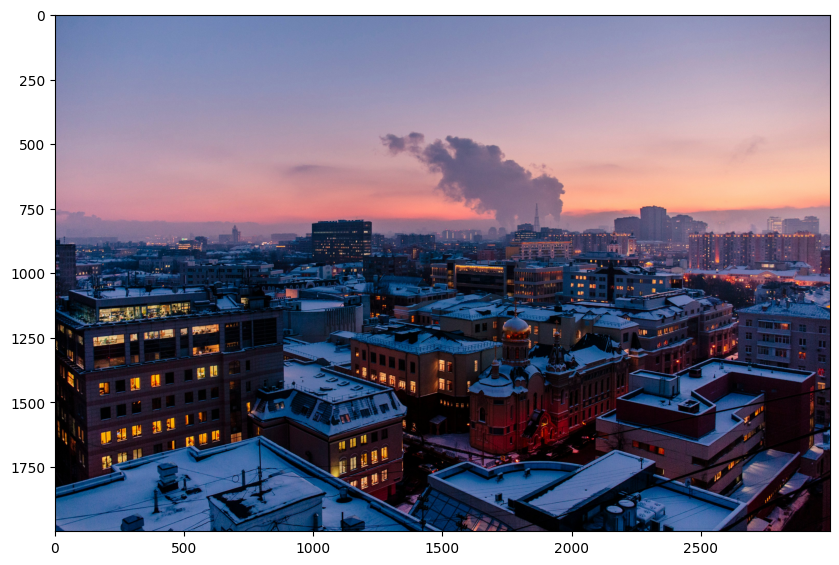

In [4]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("on")
plt.show()

In [5]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

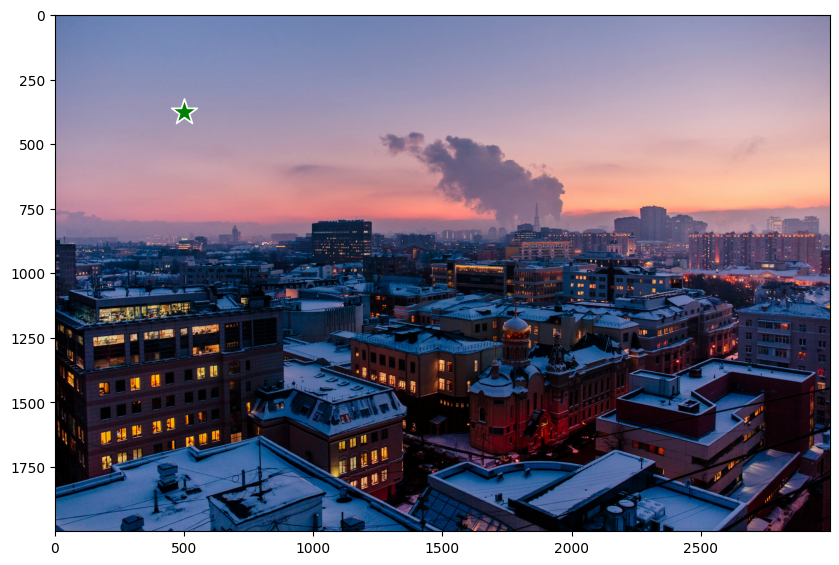

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis("on")
plt.show()

In [7]:
predictor = SAM2ImagePredictor.from_pretrained(
    "facebook/sam2-hiera-tiny", device=torch.device("mps")
)

/Users/ivyzhang/src/nameguessr/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
with torch.inference_mode(), torch.autocast("mps", dtype=torch.bfloat16):
    predictor.set_image(image)


In [9]:
print(
    predictor._features["image_embed"].shape,
    predictor._features["image_embed"][-1].shape,
)

torch.Size([1, 256, 64, 64]) torch.Size([256, 64, 64])


In [10]:
with torch.inference_mode(), torch.autocast("mps", dtype=torch.bfloat16):
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

In [11]:
masks.shape

(3, 1999, 3000)

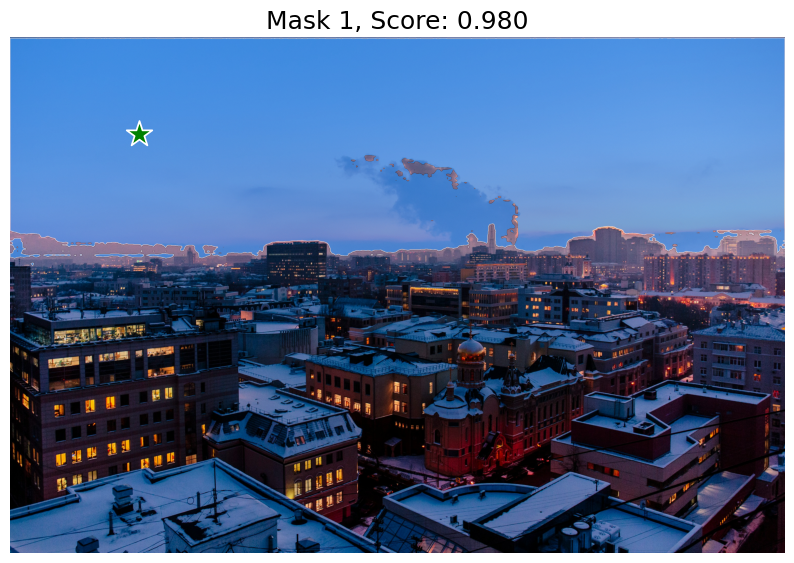

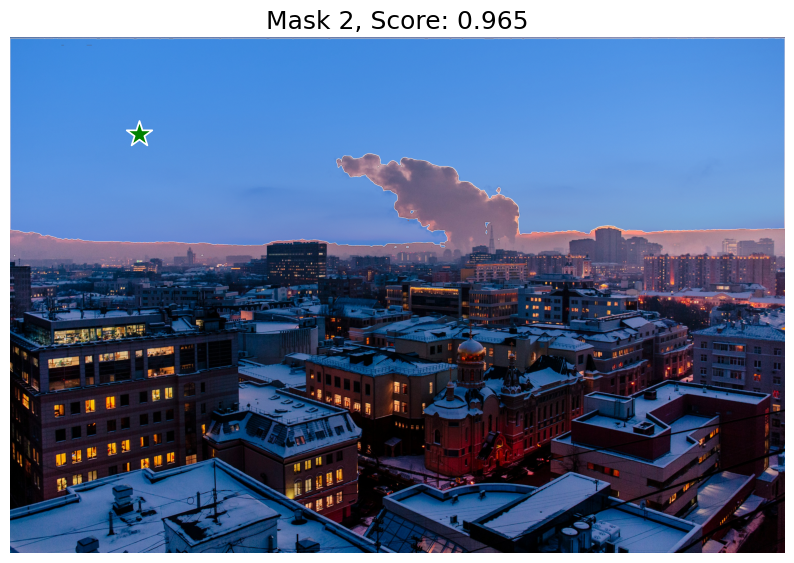

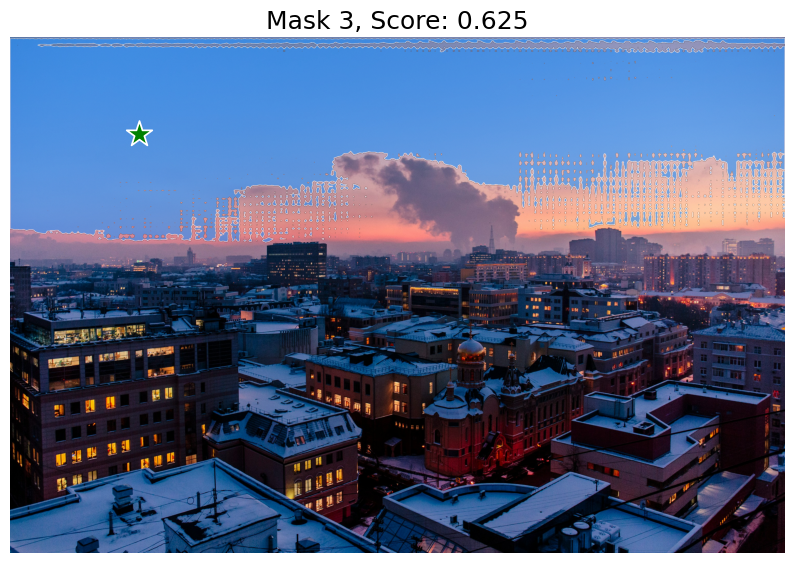

In [12]:
show_masks(
    image,
    masks,
    scores,
    point_coords=input_point,
    input_labels=input_label,
    borders=True,
)

**Video Predictions!**


In [13]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from sam2.sam2_video_predictor import SAM2VideoPredictor

In [14]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )
    torch.autocast("mps", dtype=torch.bfloat16).__enter__()

using device: mps

Support for MPS devices is preliminary. SAM 2 is trained with CUDA and might give numerically different outputs and sometimes degraded performance on MPS. See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion.


In [15]:
predictor = SAM2VideoPredictor.from_pretrained(
    "facebook/sam2-hiera-tiny", device=device
)

In [16]:
#
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )

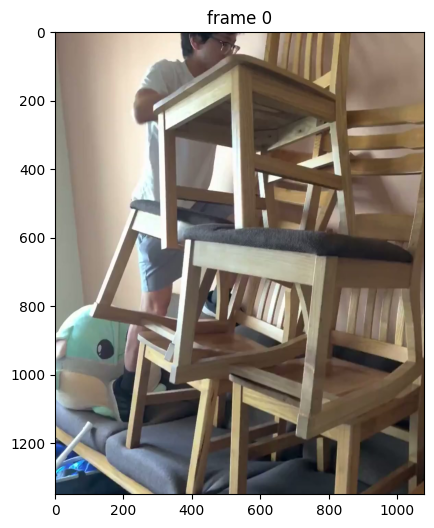

In [18]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./assets/climbing_4x5_frames"

# scan all the JPEG frame names in this directory
frame_names = [
    p
    for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [19]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 282/282 [00:05<00:00, 50.43it/s]


In [20]:
predictor.reset_state(inference_state)

/Users/ivyzhang/src/nameguessr/.venv/lib/python3.11/site-packages/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/Users/ivyzhang/src/nameguessr/.venv/lib/python3.11/site-packages/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


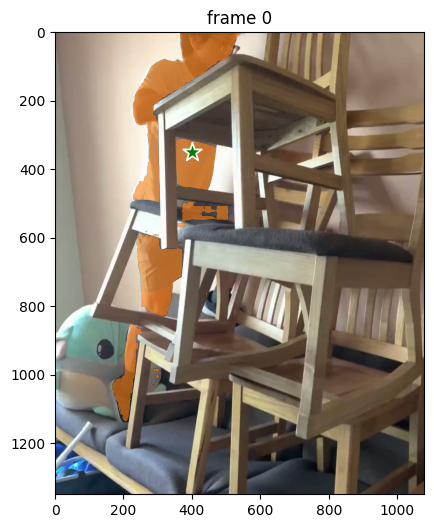

In [21]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = (
    1  # give a unique id to each object we interact with (it can be any integers)
)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[400, 350]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

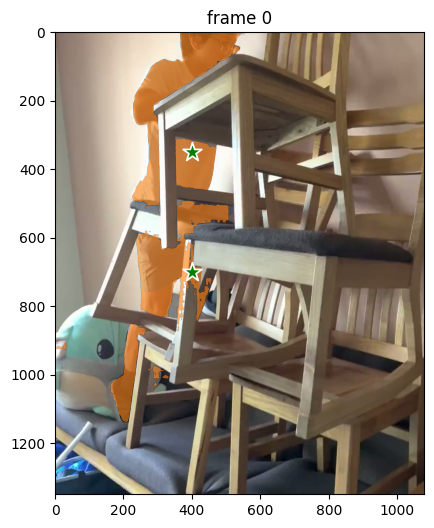

In [22]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = (
    1  # give a unique id to each object we interact with (it can be any integers)
)

# Let's add a 2nd positive click at (x, y) = (250, 220) to refine the mask
# sending all clicks (and their labels) to `add_new_points_or_box`
points = np.array([[400, 350], [400, 700]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

propagate in video: 100%|██████████| 282/282 [02:39<00:00,  1.77it/s]


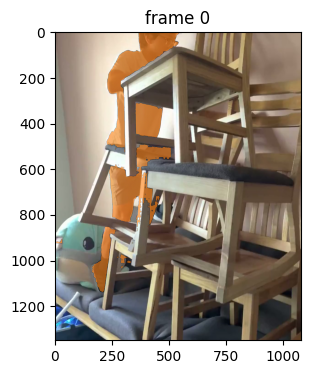

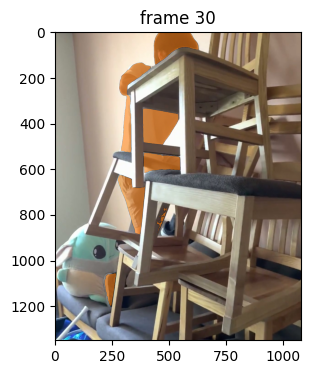

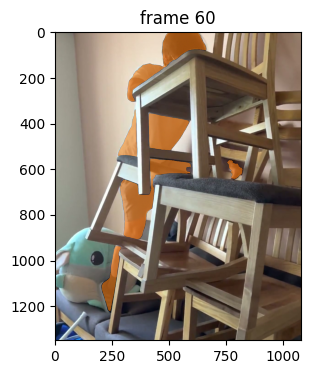

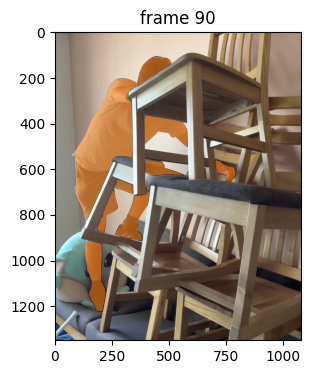

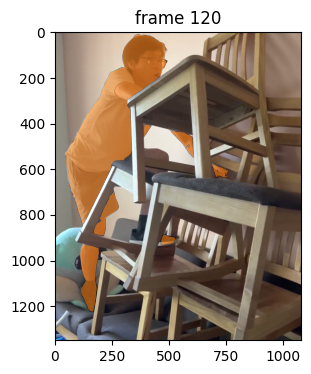

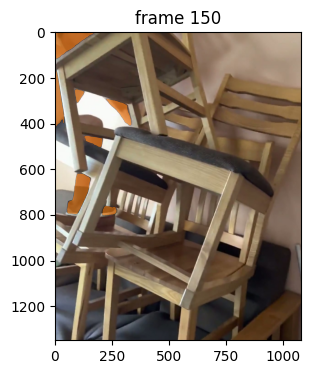

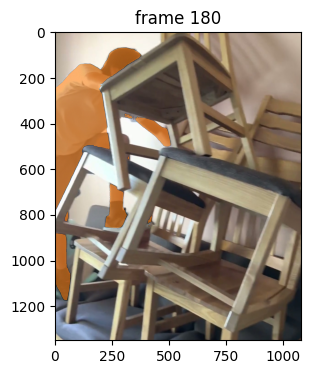

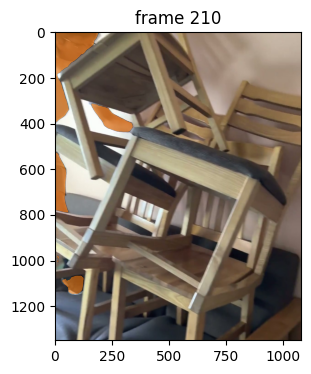

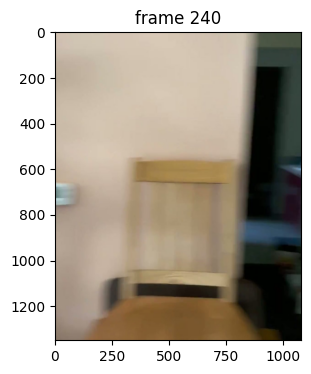

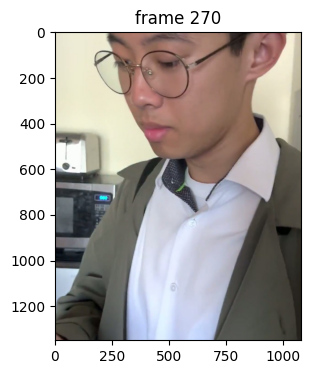

In [23]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(
    inference_state
):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

_Multiple people test_


In [48]:
predictor.reset_state(inference_state)

In [49]:
prompts = {}  # hold all the clicks we add for visualization

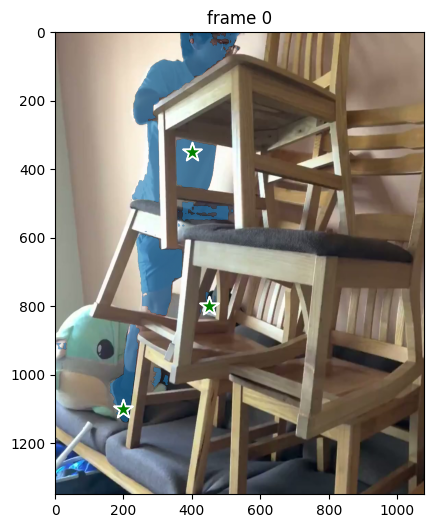

In [50]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = (
    0  # give a unique id to each object we interact with (it can be any integers)
)

# Let's add a positive click at (x, y) = (200, 300) to get started on the first object
points = np.array([[400, 350], [450, 800], [200, 1100]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 1, 1], np.int32)
prompts[ann_obj_id] = points, labels
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

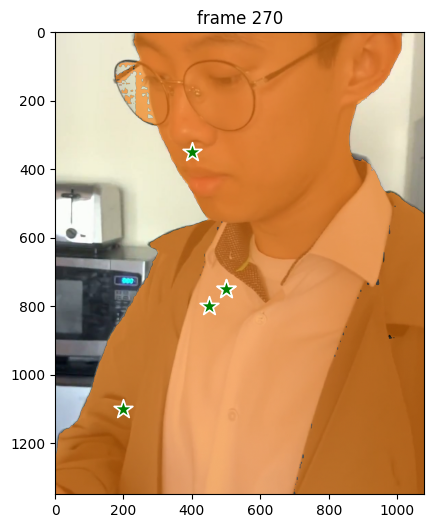

In [51]:
ann_frame_idx = 270  # the frame index we interact with
ann_obj_id = (
    1  # give a unique id to each object we interact with (it can be any integers)
)

# Let's now move on to the second object we want to track (giving it object id `3`)
# with a positive click at (x, y) = (400, 150)
points = np.array([[500, 750]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
prompts[ann_obj_id] = points, labels

# `add_new_points_or_box` returns masks for all objects added so far on this interacted frame
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame on all objects
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

propagate in video: 100%|██████████| 282/282 [04:19<00:00,  1.09it/s]


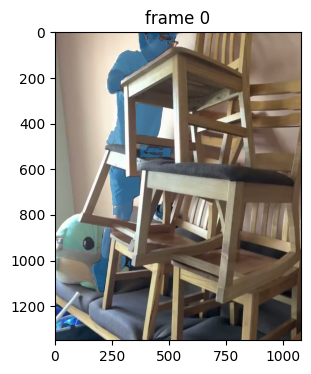

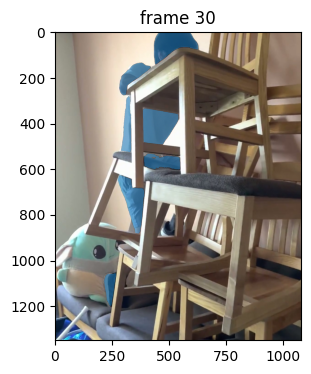

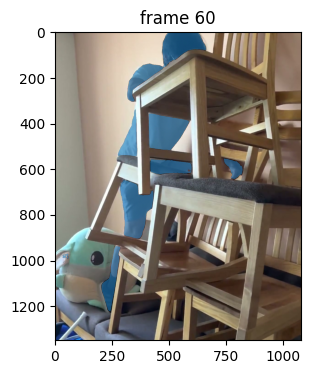

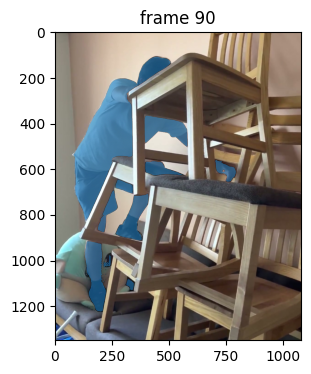

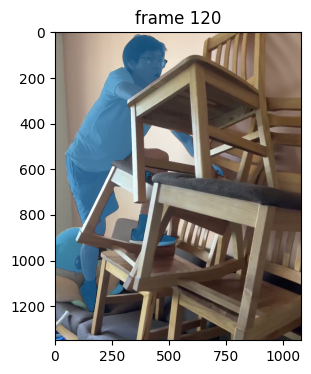

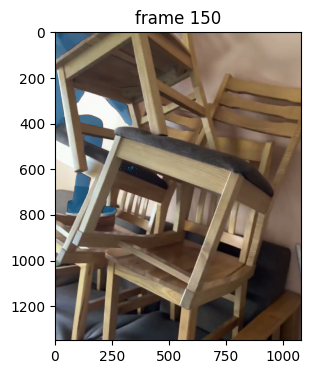

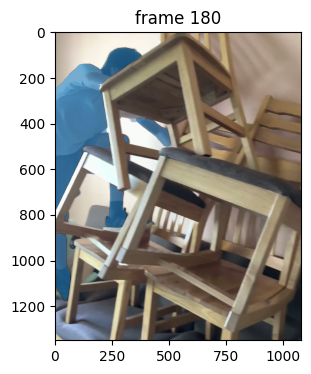

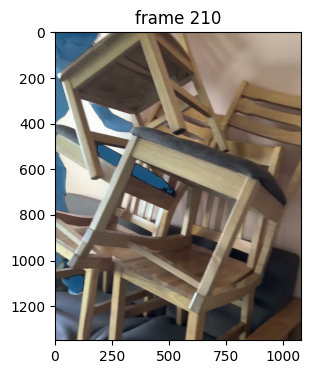

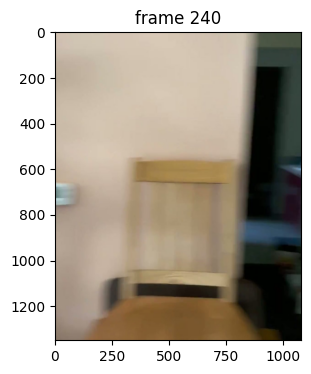

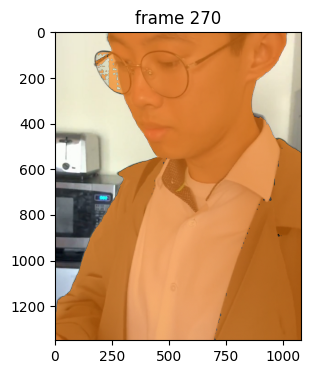

In [52]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(
    inference_state
):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [34]:
# vis_frame_stride = 10
# plt.close("all")
# for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
#     plt.figure(figsize=(6, 4))
#     plt.title(f"frame {out_frame_idx}")
#     plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
#     for out_obj_id, out_mask in video_segments[out_frame_idx].items():
#         show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [53]:
def save_mask(mask, filename, obj_id=None, random_color=False):
    """
    Try saving mask as a JPG
    """
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    print(mask_image.shape)
    plt.imsave(f"{filename}.png", mask_image)

    # ax.imshow(mask_image)

In [54]:
vis_frame_stride = 1
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        # print(out_mask.shape, out_mask.dtype, out_mask.nbytes)
        # np.save(f"masks/{out_frame_idx}", out_mask)
        save_mask(out_mask, f"masks/{out_frame_idx}_{out_obj_id}", obj_id=out_obj_id)
        # print(out_frame_idx)

(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1080, 4)
(1350, 1